## SIFT  Algorithm Implementation and Feature Matching

- SIFT (Scale-Invariant Feature Transform)은 이미지의 크기와 회전에 불변하는 특징을 추출하는 알고리즘이다.  
- 서로 다른 두 이미지에서 SIFT 특징을 각각 추출한 다음에 서로 가장 비슷한 특징끼리 매칭해주면      
   두 이미지에서 대응되는 부분을 찾을 수 있다는 것이 기본 원리이다.  
- openCV에 SIFT 알고리즘을 이용한 feature-detect 함수를 파이썬으로 직접 구현하고 몇가지 feature matching을 수행했다.
 


In [151]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import copy
print("done")

done


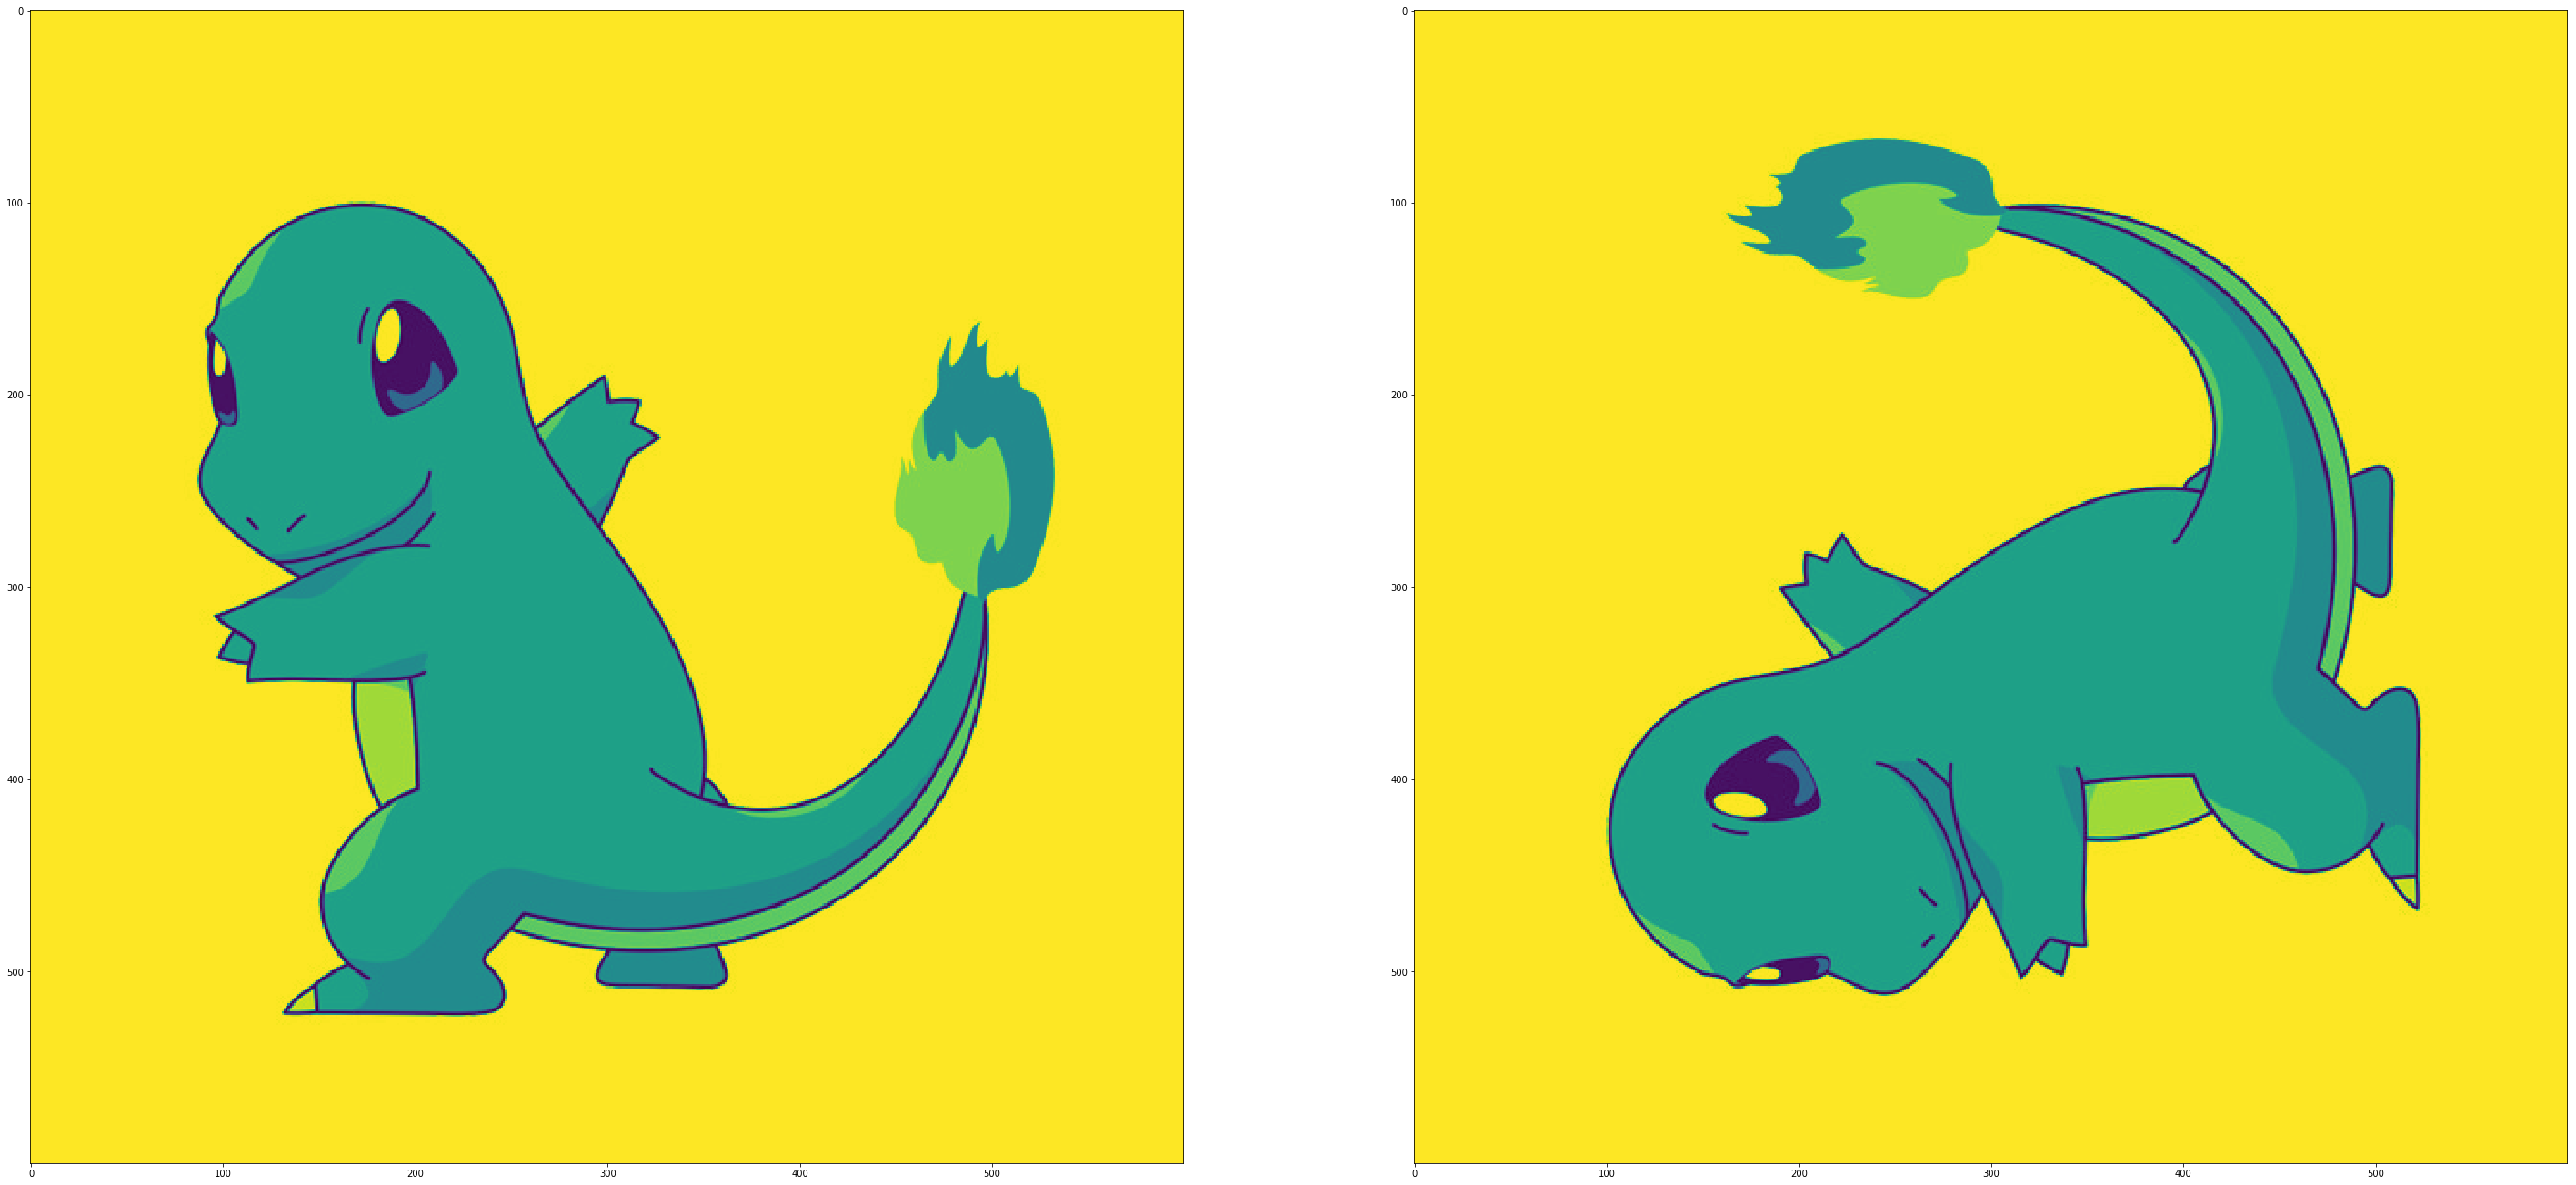

In [161]:
img = cv2.imread('./myimg/myimg1.jpg',2)
img2 = cv2.imread('./myimg/myimg2.jpg',2)
plt.figure(figsize=(50,30))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img2)

In [170]:
imgs = []
imgs.append(img)
imgs.append(cv2.resize(img, None, fx=np.sqrt(2), fy=np.sqrt(2), interpolation=cv2.INTER_AREA))
imgs.append(cv2.resize(img, None, fx=1/np.sqrt(2), fy=1/np.sqrt(2), interpolation=cv2.INTER_AREA))
imgs.append(cv2.resize(imgs[-1], None, fx=1/np.sqrt(2), fy=1/np.sqrt(2), interpolation=cv2.INTER_AREA))

imgs2 = []
imgs2 = []
imgs2.append(img2)
imgs2.append(cv2.resize(img2, None, fx=np.sqrt(2), fy=np.sqrt(2), interpolation=cv2.INTER_AREA))
imgs2.append(cv2.resize(img2, None, fx=1/np.sqrt(2), fy=1/np.sqrt(2), interpolation=cv2.INTER_AREA))
imgs2.append(cv2.resize(imgs2[-1], None, fx=1/np.sqrt(2), fy=1/np.sqrt(2), interpolation=cv2.INTER_AREA))

print("done")

done


Feature detection 
- 원본이미지를 리사이즈 하여 4 개의 이미지 피라미드를 만듬
- 각각의 이미지에 대해 cornerHarris() 함수를 이용해 feature point를 찾아낸 후 그 결과를 출력

done


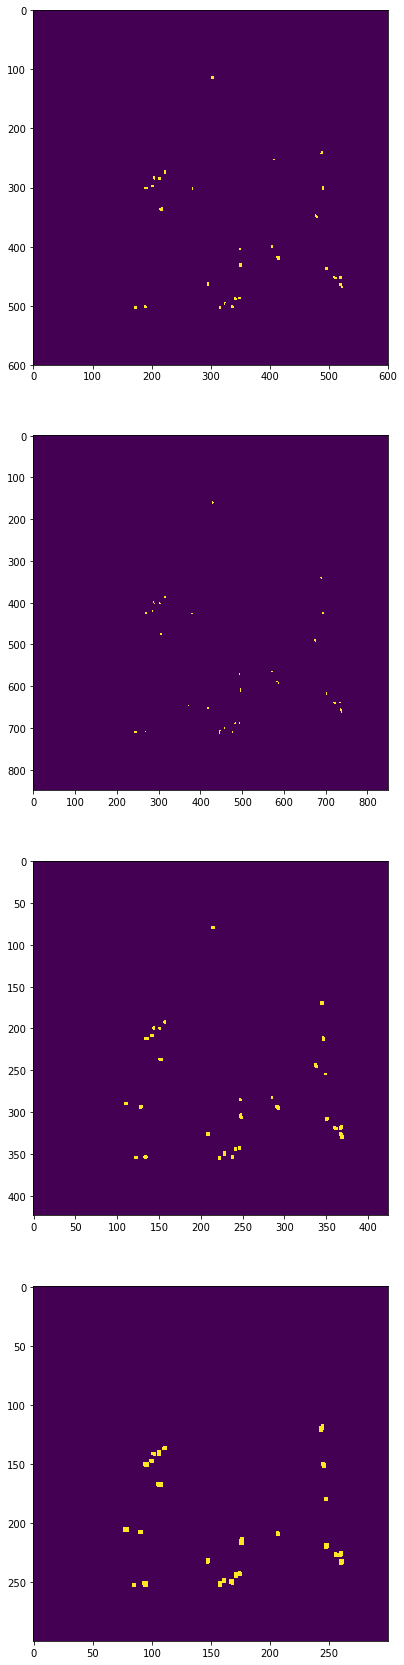

In [172]:
corners = []
plt.figure(figsize=(50,30)) 
for i in range(len(imgs)):
    image = imgs[i]
    dst = cv2.cornerHarris(image,3,3,0.1)
    dst = cv2.dilate(dst,None)
    corner = np.zeros_like(image)
    corner[dst>0.1*dst.max()]= 1
    corner_info = []
    plt.subplot(4,1,i+1)
    plt.imshow(corner)
    for x in range(corner.shape[0]):
        for y in range(corner.shape[1]):
            if(corner[x][y] == 1):
                corner_info.append([x,y])
    corners.append(corner_info)

corners2 = []
for i in range(len(imgs2)):
    image = imgs2[i]
    dst = cv2.cornerHarris(image,3,3,0.1)
    dst = cv2.dilate(dst,None)
    corner = np.zeros_like(image)
    corner[dst>0.1*dst.max()]= 1
    corner_info = []
    plt.subplot(4,1,i+1)
    plt.imshow(corner)
    for x in range(corner.shape[0]):
        for y in range(corner.shape[1]):
            if(corner[x][y] == 1):
                corner_info.append([x,y])
    corners2.append(corner_info)
    
print("done")

Dominant orientations 
- 각각의 이미지에 대해 Magnitude data, Orientation data 를 만듬
- 각 featurepoint 를 중심으로 한 window의 pixel을 순회하여orientation histogram을 만듬
- Histogram에는 픽셀의 orientation 에 해당하는 bin 에 그 픽셀의 magnitude 값이 들어간다. (hist[bin] += mag )
- histogram 을 바탕으로 dominant orientation 을 array 자료형을 사용해,      
  가장 큰 histogram 값의 0.8 배 이상인 것들은 모두 dominant orientation 으로 인정해 복수의 dominant orientation이 존재할 수 있도록 하였다. 

In [173]:
win_size = [11,7,5,5]
win_half = [5,3,2,2]

ori = [[],[],[],[]]
for i in range(4):
    image = imgs[i]
    corner = corners[i]
    Ix = cv2.Sobel(image,cv2.CV_32F,1,0,ksize=1)
    Iy = cv2.Sobel(image,cv2.CV_32F,0,1,ksize=1)
    M = np.sqrt(Ix**2 + Iy**2) # magnitudes
    O =  ((np.arctan2(Iy, Ix) + np.pi)*180)/np.pi # orientations
    for j in range(len(corners[i])):
        hist = np.zeros(36)
        x,y = corners[i][j]
        w = win_size[i]
        row = O.shape[0]
        col = O.shape[1]
        if(x-w<0 or x+w>=row or y-w<0 or y+w>=col):
            ori[i].append(None)
            continue
        else:
            O_w = O[x-win_size[i]:x+win_size[i],y-win_size[i]:y+win_size[i]]
            M_w = M[x-win_size[i]:x+win_size[i],y-win_size[i]:y+win_size[i]]
        # histogram
        for  xx in range(w):
            for yy in range(w):
                tmp = np.floor(O_w[xx][yy]/10) + 1
                tmp = int(tmp)
                if(tmp==37):
                    tmp = 36
                hist[tmp-1] = hist[tmp-1] + M_w[xx][yy]
        max_val = hist.max()
        max_idx = np.where(max_val == hist)[0][0]
        d = []
        d.append(max_idx*10)
        for h in range(len(hist)): # look for max* 0.8
            if(hist[h] > 0.8*max_val and h != max_idx):
                d.append(h*10)
        ori[i].append(d)
print("ori1 done")
ori2 = [[],[],[],[]]
for i in range(4):
    image = imgs2[i]
    corner = corners2[i]
    Ix = cv2.Sobel(image,cv2.CV_32F,1,0,ksize=1)
    Iy = cv2.Sobel(image,cv2.CV_32F,0,1,ksize=1)
    M = np.sqrt(Ix**2 + Iy**2) # magnitudes
    O =  ((np.arctan2(Iy, Ix) + np.pi)*180)/np.pi # orientations
    for j in range(len(corners2[i])):
        hist = np.zeros(36)
        x,y = corners2[i][j]
        w = win_size[i]
        row = O.shape[0]
        col = O.shape[1]
        if(x-w<0 or x+w>=row or y-w<0 or y+w>=col):
            ori[i].append(None)
            continue
        else:
            O_w = O[x-win_size[i]:x+win_size[i],y-win_size[i]:y+win_size[i]]
            M_w = M[x-win_size[i]:x+win_size[i],y-win_size[i]:y+win_size[i]]
        # histogram
        for  xx in range(w):
            for yy in range(w):
                tmp = np.floor(O_w[xx][yy]/10) + 1
                tmp = int(tmp)
                if(tmp==37):
                    tmp = 36
                hist[tmp-1] = hist[tmp-1] + M_w[xx][yy]
        max_val = hist.max()
        max_idx = np.where(max_val == hist)[0][0]
        d = []
        d.append(max_idx*10)
        for h in range(len(hist)): # look for max* 0.8
            if(hist[h] > 0.8*max_val and h != max_idx):
                d.append(h*10)
        ori2[i].append(d)

print("ori2 done")

ori1 done
ori2 done


Rotational invariance 
- Featue point 를 기준으로 23x23 window 만큼 crop 해준뒤 위에서 구한 dominant orientation만큼 회전시켜준다. 
- 만약 다수의 dominant orientation이 존재 할 경우를 생각하여, dominant orientation data 의 평균값을 사용하였다. 
- 회전한 이미지를 다시 16x16 window 로 crop 해준뒤  위에서 histogram 을 구했던것과 동일하게 4x4 window 를 기준으로 구하고        
     16개의 histogram 을 concatenating 하여 128 dimensional vector 를 만들어냈다. 
- 이 128 dimensional vector가 각각 feature point 고유의 특징 데이터라고 볼 수 있다. 
 

In [175]:
featuredata = [[],[],[],[]]
for i in range(4):
    print(i)
    image = imgs[i];
    corner = corners[i]
    for j in range(len(corner)):
        if(ori[i][j]==None):
            featuredata[i].append(None)
            continue
        x,y = corner[j]
        w = 11
        row = image.shape[0]
        col = image.shape[1]
        win23 = np.zeros((23,23))
        for xx in range(23):
            for yy in range(23):
                if(x-w+xx<0 or x-w+xx>=row or y-w+yy<0 or y-w+yy>=col):
                    continue
                else:
                    win23[xx][yy] = image[x-w+xx][y-w+yy]
        angle = np.mean(ori[i][j]) # mean angle
        rmatrix = cv2.getRotationMatrix2D((11,11), angle, 1)
        window_rotated = cv2.warpAffine(win23, rmatrix, (23, 23))
        win16 = window_rotated[4:19,4:19] # 16x16 rotated window
        Ix16 = cv2.Sobel(win16,cv2.CV_64F,1,0,ksize=1)
        Iy16 = cv2.Sobel(win16,cv2.CV_64F,0,1,ksize=1)
        M_16 = np.sqrt(Ix16**2+ Iy16**2) # magnitudes
        O_16 = ((np.arctan2(Iy, Ix) + np.pi)*180)/np.pi # orientations
        data = []; num_x = 1
        for ii in range(4,12):
            for jj in range(4,12):  # 4x4
                hist = np.zeros(8)
                tmp_m = M_16[ii:ii+3,jj:jj+3]
                tmp_o = O_16[ii:ii+3,jj:jj+3]
                for xx in range(3):
                    for yy in range(3):
                        tmp = np.floor(tmp_o[xx][yy]/44) + 1
                        tmp = int(tmp)
                        if(tmp==9):
                            tmp = 8
                        hist[tmp-1] = hist[tmp-1] + tmp_m[xx][yy]
                if data==[]:
                    data = hist
                else:
                    data = np.concatenate((data,hist),axis=0)
        featuredata[i].append(data)
        
print("featuredata1 done")  
        
featuredata2 = [[],[],[],[]]
for i in range(4):
    print(i)
    image = imgs2[i];
    corner = corners2[i]
    for j in range(len(corner)):
        if(ori2[i][j]==None):
            featuredata2[i].append(None)
            continue
        x,y = corner[j]
        w = 11
        row = image.shape[0]
        col = image.shape[1]
        win23 = np.zeros((23,23))
        for xx in range(23):
            for yy in range(23):
                if(x-w+xx<0 or x-w+xx>=row or y-w+yy<0 or y-w+yy>=col):
                    continue
                else:
                    win23[xx][yy] = image[x-w+xx][y-w+yy]
        angle = np.mean(ori2[i][j]) # mean angle
        rmatrix = cv2.getRotationMatrix2D((11,11), angle, 1)
        window_rotated = cv2.warpAffine(win23, rmatrix, (23, 23))
        win16 = window_rotated[4:19,4:19] # 16x16 rotated window
        Ix16 = cv2.Sobel(win16,cv2.CV_64F,1,0,ksize=1)
        Iy16 = cv2.Sobel(win16,cv2.CV_64F,0,1,ksize=1)
        M_16 = np.sqrt(Ix16**2+ Iy16**2) # magnitudes
        O_16 = ((np.arctan2(Iy, Ix) + np.pi)*180)/np.pi # orientations
        data = []; num_x = 1
        for ii in range(4,12):
            for jj in range(4,12):  # 4x4
                hist = np.zeros(8)
                tmp_m = M_16[ii:ii+3,jj:jj+3]
                tmp_o = O_16[ii:ii+3,jj:jj+3]
                for xx in range(3):
                    for yy in range(3):
                        tmp = np.floor(tmp_o[xx][yy]/44) + 1
                        tmp = int(tmp)
                        if(tmp==9):
                            tmp = 8
                        hist[tmp-1] = hist[tmp-1] + tmp_m[xx][yy]
                if data==[]:
                    data = hist
                else:
                    data = np.concatenate((data,hist),axis=0)
        featuredata2[i].append(data)
print("featuredata2 done")  

0


C:\Users\GUR\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1
2
3
featuredata1 done
0


C:\Users\GUR\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:91: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


1
2
3
featuredata2 done


Illumination change invariance 
- Illunination invariance를 얻기 위해 위에서 구한 128 dimensional vector 를 normalize해준다. 
- 데이터를 L2 Norm 으로 나눠서 normalized 된 feature data 를 만들어냈다. 
- 상수값을 곱해 밝기값이 변경되는 경우 normalize 를 통해 illumination invariance 를 얻을 수 있지만,       
     달리 상수값을 더해 이미지를 변경 했을 경우에는 밝기 변화를 배제해주는 효과를 기대하기 어렵다.

In [176]:
nfd = [[],[],[],[]]
for i in range(3):
    print(i)
    mage = imgs[i];
    corner = corners[i]
    for j in range(len(corner)):
        tmp = featuredata[i][j]
        if(tmp is None):
            continue
        else:
            normalized = tmp/np.linalg.norm(tmp)
            nfd[i].append([normalized,j])
print("nfd1 done")


nfd2 = [[],[],[],[]]
for i in range(3):
    print(i)
    mage = imgs2[i];
    corner = corners2[i]
    for j in range(len(corner)):
        tmp = featuredata2[i][j]
        if(tmp is None):
            continue
        else:
            normalized = tmp/np.linalg.norm(tmp)
            nfd2[i].append([normalized,j])
print("nfd2 done")

0
1
2
nfd1 done
0
1
2
nfd2 done


Feature matching 
- Feature data 간의 L2 distatance 기준으로 matching 하였다. 
- 이미지 1 의 featuredata 의 특정 feature data와 이미지2의 모든 feature data를 비교하여 가장 작을 때로 matching
- L2 distance에 threshold를 주어 낮은 값을 가지는 결과만을 출력하였다. 
- affine image 세트 같은 경우 이미지 내의 비슷한 패턴이 많아 이미지에서 도출해낸 featuredata 가 비슷한 값들이 많아     
    정확히 matching 된 결과가 얼마 존재하지 않았다. 

In [177]:
i = 0; j = 0
image1 = imgs[i];
corner1 = corners[i]
feature1 = nfd[i]
image2 = imgs2[j];
corner2 = corners2[j]
feature2 = nfd2[j]

l2d = []
for m in range(len(feature1)):
    tmps = []
    for n in range(len(feature2)):
        f1 = feature1[m][0]
        f2 = feature2[n][0]
        delta = np.linalg.norm(f1-f2)
        tmps.append([delta,m,n])
    l2d.append(min(tmps))
    
print("done",len(l2d))

('done', 613)


In [178]:
matchedPoints1 = []
matchedPoints2 = []
for i in range(len(l2d)):
    if(l2d[i][0]<0.1):
        m = l2d[i][1]
        n = l2d[i][2]
        p1 = feature1[m][1]
        p2 = feature2[n][1]
        x1,y1 = corners[0][p1]
        x2,y2 = corners2[0][p2]
        matchedPoints1.append((x1,y1))
        matchedPoints2.append((x2,y2))
mp1 = np.array(matchedPoints1)
mp2 = np.array(matchedPoints2)
mp2 = matchedPoints2 + np.array([0,img.shape[0]])
print("done")

done


cornerHarris() 로 corner points 를 뽑아내는과정에서의 이미지 1, 이미지 2 에서서의 threshold와, 출력시의 threshold 값을 적절히 조정하여 다음과 같은 결과를 얻었다. rotation된 이미지에서 정상적으로 feature detect된 결과를 확인할 수 있었다. 이외에도 SIFT 알고리즘의 특징인 scale, illumination, transition, occlusion에서 마찬가지로 양호한 결과가 나왔다

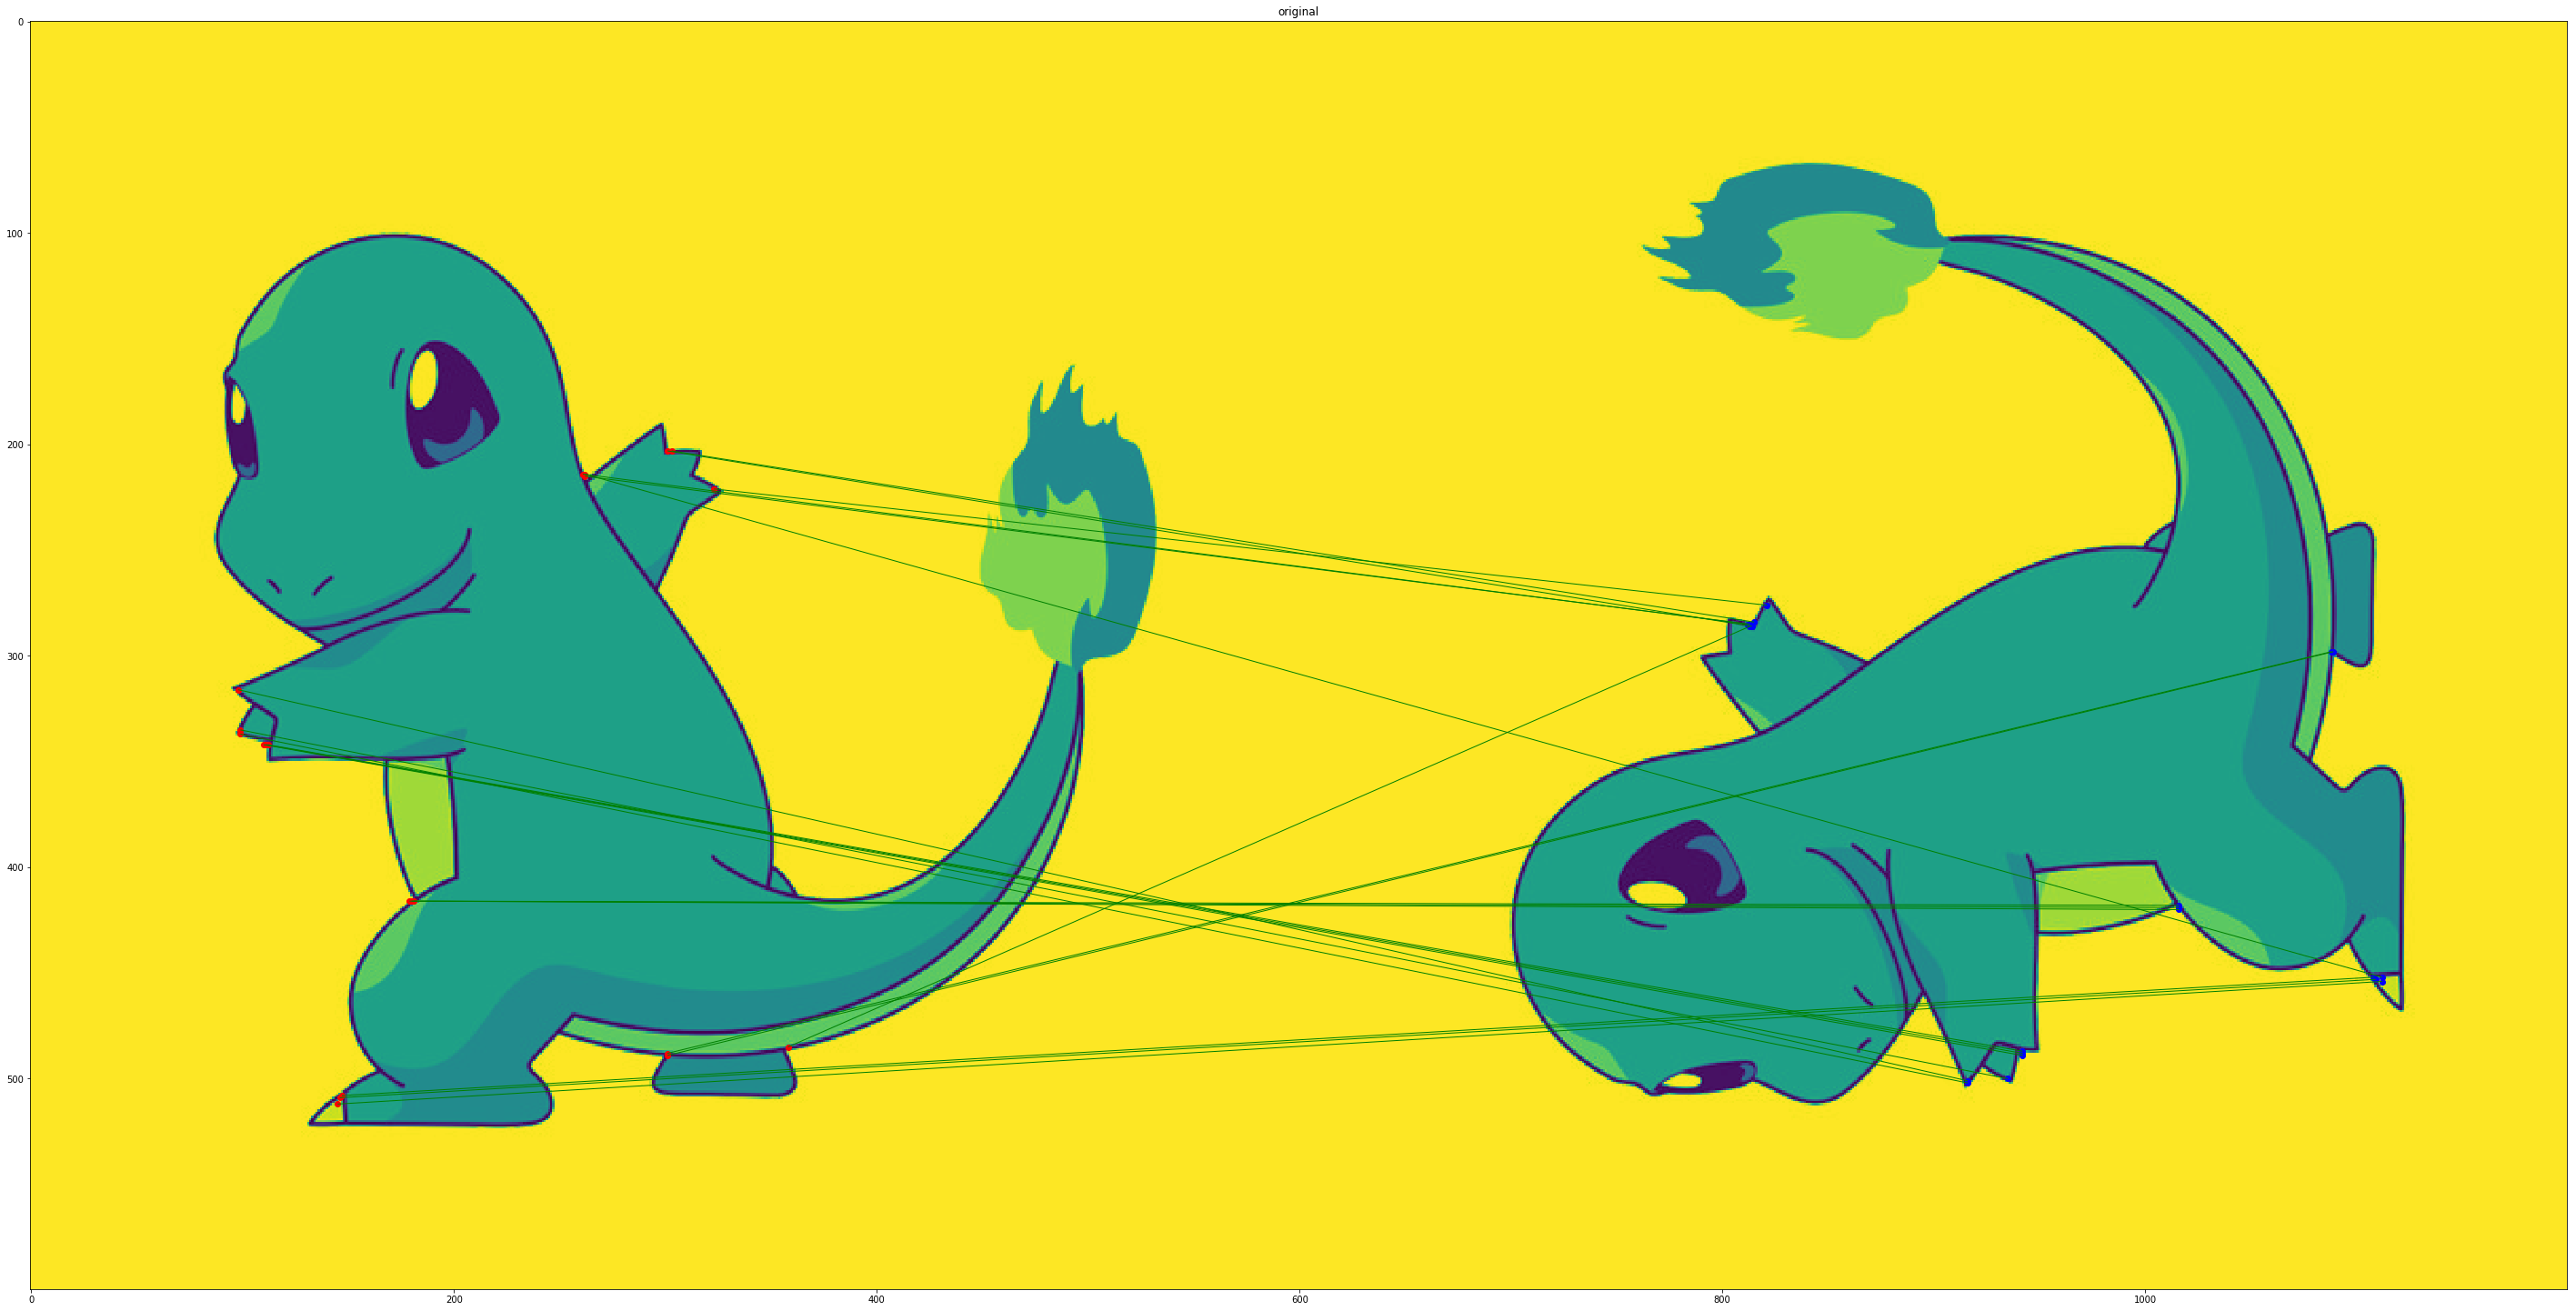

In [179]:
img_new = np.concatenate((img,img2),1)
plt.figure(figsize=(50,30)) 
plt.subplot(1,1,1)
plt.title('original')
plt.imshow(img_new)
plt.scatter(mp1[:,1],mp1[:,0],color='r')
plt.scatter(mp2[:,1],mp2[:,0],color='b')
for i in range(len(mp1)):
    pa = [mp1[i,1], mp1[i,0]]
    pb = [mp2[i,1], mp2[i,0]]    
    line = plt.Polygon([pa,pb], closed=None, fill=None, edgecolor='g')
    plt.gca().add_line(line)